# Notebook to Investigate LSTM Performance Variance MSE v Hybrid Loss Function 

# Step 0 - Set up Notebook

In [6]:
# import needed libaries
import os
import boto3
import mlflow
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [8]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [30]:
def extract_step(df, step):
    df_filtered = df[df["Step"] == step].copy()
    return df_filtered

In [10]:
# function to extract only a specific metric if metric ends with name 
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [50]:
# Function to extract only a specific metric
def extract_metric_start(df, metric_name):
    """Extracts rows where the Metric column begins with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.startswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')


In [28]:
# set mlFlow tracking server 
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"

Skagit12_16 = "215fe6997cc04f4493cce8d003dea9a5" # Skagit 12, batch size 16, epochs 10, nosy robin
Skagit12_64 = "d2f3f6f705014660917cfae0c0716236"  # Skagit 12 with 64 Batch size, MSEloss "nervous sponge"



In [48]:
def get_metric_dfs(run_id, epochs):
    metrics_all = load_ml_metrics(tracking_uri, run_id, save_local = True)
    metrics_step = extract_step(metrics_all, epochs-1)
    df_tkge = extract_metric_start(metrics_step, "test_kge")
    df_mse = extract_metric_start(metrics_step, "test_mse")
    return df_tkge, df_mse

In [51]:
Sk12_16mseloss_tkge, Sk12_16mseloss_tmse = get_metric_dfs(Skagit12_16, 10)
Sk12_16mseloss_tkge.head(2)

,Metric,Value
59,test_kge_171100050401,0.905121
99,test_kge_171100050402,0.870059


In [52]:
Sk12mseloss_tkge, Sk12_mseloss_tmse = get_metric_dfs(Skagit12_64, 10)
Sk12mseloss_tkge.head(2)

,Metric,Value
619,test_kge_171100050401,0.933558
679,test_kge_171100050402,0.953840


# Step2 - Define Plotting Function

In [53]:
# define a function to plot results side by side 

def plot_side_by_side(*dfs_labels, title = "Side-by-Side Metric Comparison"):
    """Plots a side-by-side bar chart comparing values from multiple DataFrames by Metric.
    
    Parameters:
        *dfs_labels: Variable-length arguments where each pair is (df, label).
                     Example usage: plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")
    """
    
    if len(dfs_labels) % 2 != 0:
        raise ValueError("Arguments must be given as (df1, label1, df2, label2, ...).")
    
    # Process input pairs
    dfs = dfs_labels[0::2]
    labels = dfs_labels[1::2]

    # Merge all DataFrames on 'Metric'
    merged_df = dfs[0][['Metric', 'Value']].rename(columns={'Value': f'Value_{labels[0]}'})
    for df, label in zip(dfs[1:], labels[1:]):
        merged_df = merged_df.merge(df[['Metric', 'Value']], on='Metric', how='inner', suffixes=('', f'_{label}'))
        merged_df = merged_df.rename(columns={'Value': f'Value_{label}'})  # Rename to avoid conflicts

    metrics = merged_df['Metric']
    values = [merged_df[f'Value_{label}'] for label in labels]
    medians = [np.median(val) for val in values]
    
    x = np.arange(len(metrics))  # Label locations
    width = 0.8 / len(labels)  # Adjust bar width dynamically based on the number of datasets
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each dataset
    for i, (val, label, median) in enumerate(zip(values, labels, medians)):
        bars = ax.bar(x + (i - len(labels)/2) * width, val, width, label=label, alpha=0.7)
        color = bars[0].get_facecolor()  # Get the color of the bars
        # Draw a median line for each dataset
        ax.axhline(y=median, color=bars[0].get_facecolor(), linestyle='dashed', linewidth=2, alpha=0.8)
        ax.text(len(metrics) + 0.1, median, f"{label} Median: {median:.2f}", 
                va='center', ha='left', color=color, fontsize=10, fontweight='bold')
       
    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.legend()

    plt.show()

# Example usage:
# plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")

# Step 3 Compare Results 

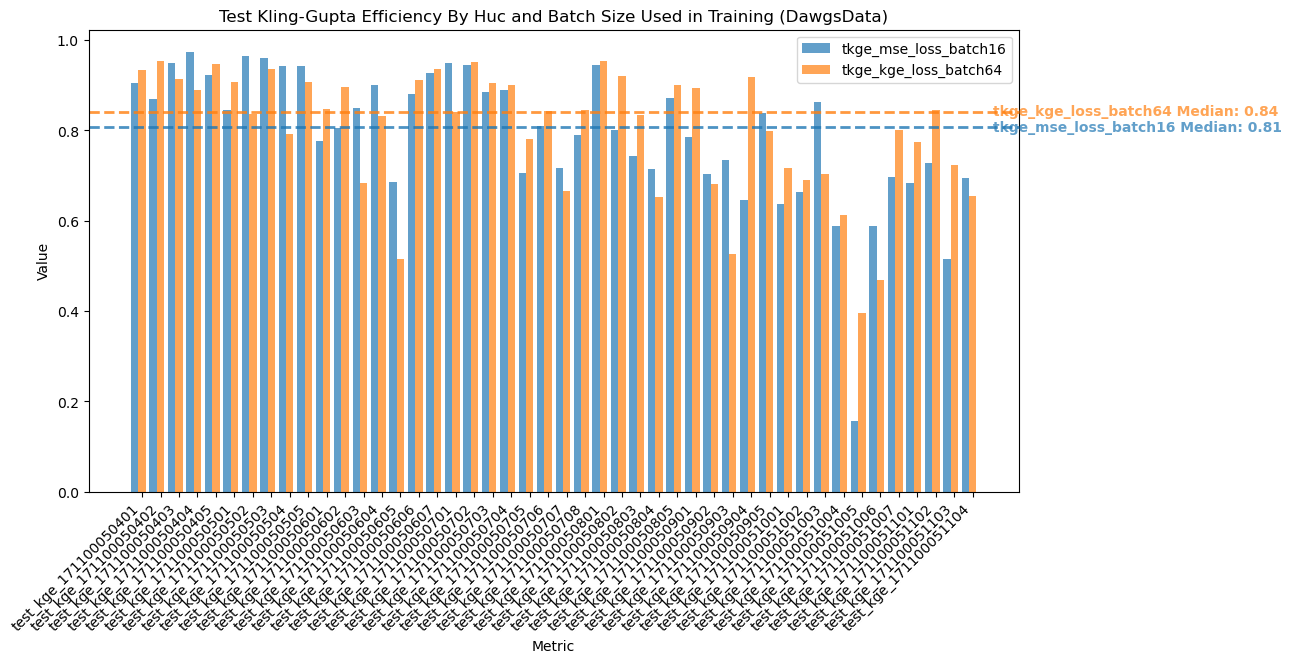

In [55]:
# Test Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(Sk12_16mseloss_tkge, "tkge_mse_loss_batch16", 
                  Sk12mseloss_tkge, "tkge_kge_loss_batch64", 
                  title = "Test Kling-Gupta Efficiency By Huc and Batch Size Used in Training (DawgsData)")

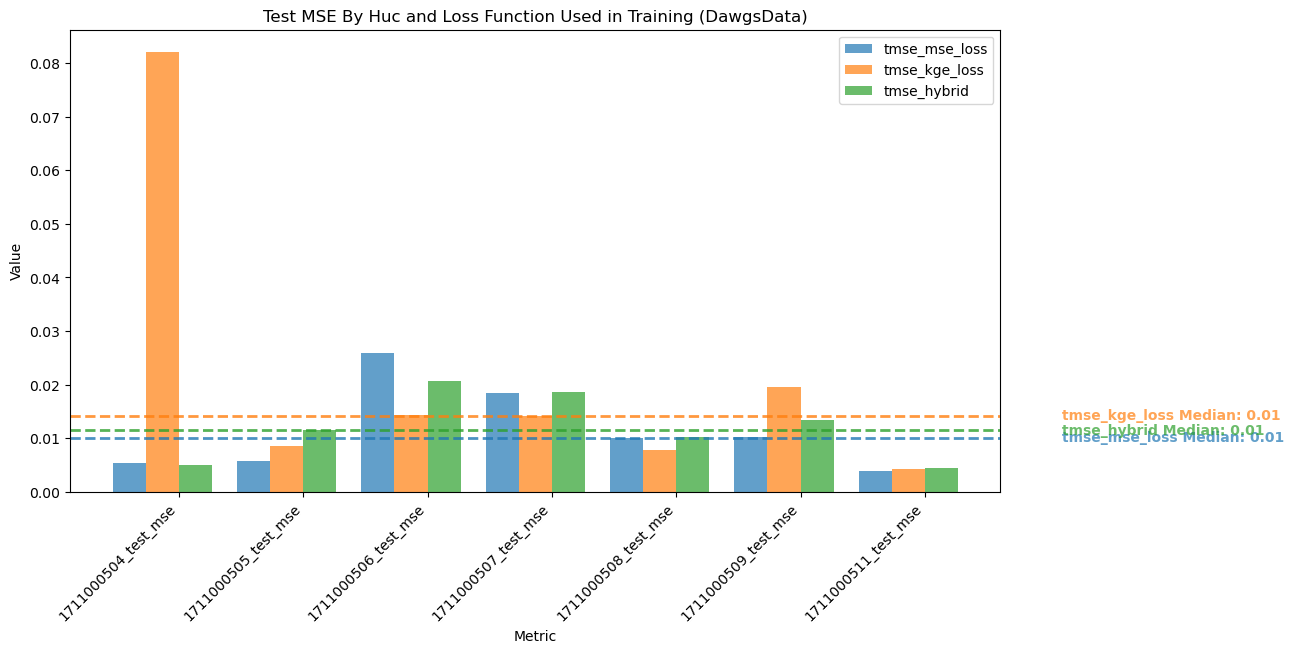

In [24]:
# Test MSE (Lower is better; 1 is Perfect) 
plot_side_by_side(df_mse_loss_tmse, "tmse_mse_loss", 
                  df_kge_loss_tmse, "tmse_kge_loss", 
                  df_hybrid_tmse, "tmse_hybrid",
                  title = "Test MSE By Huc and Loss Function Used in Training (DawgsData)")